# Accediendo a datos de modelos CMIP6
Este cuaderno de Jupyter muestra como acceder a datos de modelos CMIP6 utilizando la Coleccion Pangeo Cloud a traves de las bibliotecas `intake` y `xmip`. Ademas se muestra como hacer una manipulacion de datos sencilla con `xarray` para crear mapas utilizando las bibliotecas `matplotlib` y `cartopy`.

In [24]:
import xarray as xr
import numpy as np
import intake
from xmip.preprocessing import rename_cmip6, replace_x_y_nominal_lat_lon
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import os
import dask

In [2]:
#Asegurandose de mostrar graficos dentro del cuaderno Jupyter
%matplotlib inline

# Cargando datos CMIP6 con las bibliotecas `intake` y `xmip`
Si quisieras mas informacion sobre como funciona el paquete `intake`, puedes referirte a la documentacion, la cual esta solamente disponible en ingles [aqui](https://intake.readthedocs.io/en/latest/start.html). Tutoriales del uso de `xmip` estan disponibles en ingles [aqui](https://cmip6-preprocessing.readthedocs.io/en/latest/tutorial.html).

In [3]:
#Abriremos una conexion con la coleccion de Pangeo Cloud
coleccion_pangeo = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [4]:
#Veamos los modelos CMIP6 disponibles en la coleccion
coleccion_pangeo.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
...,...,...,...,...,...,...,...,...,...,...,...
514813,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514814,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tauu,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514815,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,hur,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514816,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,hus,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207


Como pueden notar, existen una gran cantidad de modelos CMIP6 disponibles a traves de Pangeo. Para este ejercicio, nos vamos a enfocar en uno de estos modelos que fue escogido previamente. Pero si quisieras saber mas sobre los modelos CMIP6, puedes referirte al sitio web de [World Climate Research Programme (WCRP)](https://www.wcrp-climate.org/modelling-wgcm-mip-catalogue/modelling-wgcm-cmip6-endorsed-mips).

Vale la pena recalcar que las variables ambientales estan guardadas con codigos especificos que han sido estandarizados para todos los modelos CMIP6. Puedes encontrar la variable de tu interes utilizando esta [pagina web](https://clipc-services.ceda.ac.uk/dreq/mipVars.html). Para este ejercicio una variable fue previamente seleccionada.

Finalmente, tampoco es necesario usar todos los campos que se muestran abajo. Todos estan siendo utilizados para mostrar las opciones disponibles.

In [5]:
#Inicimos una busqueda para datos historicos de la temperatura de superficie del oceano en dos modelos
busq = coleccion_pangeo.search(variable_id = 'tos', #el codigo que se refiere a la temperatura del oceano
                                 experiment_id = 'historical', #datos historicos, cubre el periodo de 1850 a 2014.
                                 source_id = ['IPSL-CM6A-LR', 'GFDL-ESM4'], #modelos de nuestro interes, ACCESS-ESM1.5
                                 table_id = 'Omon', #codigo que se refiere a datos oceanicos almacenados por mes
                                 member_id = 'r1i1p1f1') #codigo de experimento

In [6]:
#Veamos los resultados de esta busqueda
busq.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
1,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726
2,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726


Ahora que identificamos a los datos que nos interesan, entonces vamos a guardar esta informacion en un diccionario.

In [7]:
datos_dict = busq.to_dataset_dict(zarr_kwargs={'consolidated': True, #Consolidar todos los datos
                                                 'use_cftime': True}, #Guardar fecha/hora con formato cftime
                                    storage_options = {'token': 'anon'}, #Nos permite acceder a los datos en Pangeo Cloud
                                    aggregate = True,
                                    preprocess = rename_cmip6) #Estandarizacion de nombres de variables


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


C:\Users\ldfierro\AppData\Local\Temp\ipykernel_22744\3965762814.py:1: DeprecationWarning: cdf_kwargs and zarr_kwargs are deprecated and will be removed in a future version. Please use xarray_open_kwargs instead.
  datos_dict = busq.to_dataset_dict(zarr_kwargs={'consolidated': True, #Consolidar todos los datos


c:\Users\ldfierro\Anaconda3\envs\CMIP6_Python\lib\site-packages\xmip\preprocessing.py:84: UserWarning: rename 'bnds' to 'bnds' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  return obj.rename({kk: vv for kk, vv in rdict.items() if kk in obj.dims})


Veamos los resultados de nuestra busqueda y de la estandarizacion de los nombres de las variables.

In [9]:
for modelo, sd in datos_dict.items():
    print(modelo, list(sd.dims))

CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn ['y', 'x', 'vertex', 'time', 'bnds', 'member_id', 'dcpp_init_year']
CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gr ['y', 'bnds', 'x', 'time', 'member_id', 'dcpp_init_year']
CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gn ['x', 'y', 'vertex', 'bnds', 'time', 'member_id', 'dcpp_init_year']


# Manipulando y visualizando datos

Para las siguientes secciones nos vamos a enfocar en un solo modelo.

In [35]:
#El primer paso es asegurarnos que los set de datos tienen coordenadas y no solamente indices
temperaturas = replace_x_y_nominal_lat_lon(datos_dict['CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn'])
temperaturas

<xarray.Dataset>
Dimensions:         (y: 332, x: 362, vertex: 4, time: 1980, bnds: 2,
                     member_id: 1, dcpp_init_year: 1)
Coordinates:
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
  * x               (x) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * y               (y) float32 -78.08 -78.05 -78.01 -77.98 ... 89.37 89.74 90.0
Dimensions without coordinates: vertex, bnds
Data variables:
    area            (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    lat_bounds      (y, x, vertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    lon_bounds      (y, x, vertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    lat             (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    lon             (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    time_bounds     (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    tos             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 252, 332, 362), meta=np.ndarray>
Attributes: (12/67)
    CMIP6_CV_version:                 cv=6.2.3.5-2-g63b123e
    Conventions:                      CF-1.7 CMIP-6.2
    EXPID:                            historical
    NCO:                              "4.6.0"
    activity_id:                      CMIP
    branch_method:                    standard
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR...
    intake_esm_attrs:version:         20180803
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn

Tenemos datos disponibles desde 1850, pero en realidad solo nos interesan cambios en temperaturas desde 1960. Asi que recortemos estos datos.

In [37]:
temp_actual = temperaturas.tos.sel(time = slice('1960', '2014'))
#Nos deshacemos de dimensiones en el data array, pero mantenemos la informacion en las coordenadas
temp_actual = temp_actual.squeeze(('member_id', 'dcpp_init_year'))
temp_actual

<xarray.DataArray 'tos' (time: 660, y: 332, x: 362)>
dask.array<getitem, shape=(660, 332, 362), dtype=float32, chunksize=(252, 332, 362), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) object 1960-01-16 12:00:00 ... 2014-12-16 12:00:00
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
  * x               (x) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * y               (y) float32 -78.08 -78.05 -78.01 -77.98 ... 89.37 89.74 90.0
Attributes:
    cell_measures:       area: areacello
    cell_methods:        area: mean where sea time: mean
    description:         This may differ from "surface temperature" in region...
    history:             none
    interval_operation:  2700 s
    interval_write:      1 month
    long_name:           Sea Surface Temperature
    online_operation:    average
    standard_name:       sea_surface_temperature
    units:               degC

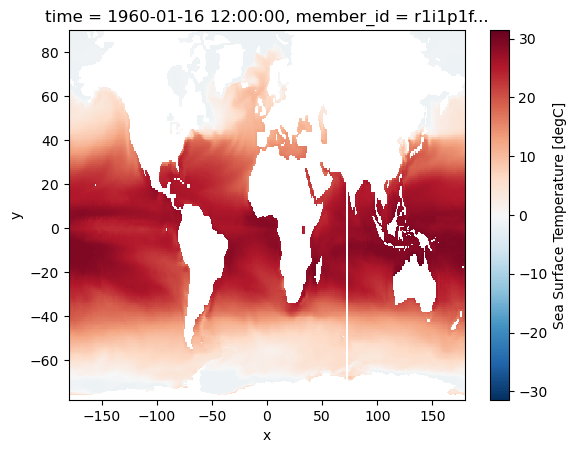

In [38]:
#Hagamos un grafico rapido de la primera fecha
temp_actual[0].plot()

El mapa se ve mucho mejor, pero supongamos que solo quisieramos enfocarnos en un area especifica, como Ecuador. Veamos como seleccionamos estos datos.

In [39]:
temp_ecu = temp_actual.sel(y = slice(-6, 3), x = slice(250, 290))
temp_ecu

<xarray.DataArray 'tos' (time: 660, y: 26, x: 0)>
dask.array<getitem, shape=(660, 26, 0), dtype=float32, chunksize=(252, 26, 0), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) object 1960-01-16 12:00:00 ... 2014-12-16 12:00:00
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
  * x               (x) float64 
  * y               (y) float32 -5.959 -5.545 -5.149 -4.769 ... 2.0 2.335 2.671
Attributes:
    cell_measures:       area: areacello
    cell_methods:        area: mean where sea time: mean
    description:         This may differ from "surface temperature" in region...
    history:             none
    interval_operation:  2700 s
    interval_write:      1 month
    long_name:           Sea Surface Temperature
    online_operation:    average
    standard_name:       sea_surface_temperature
    units:               degC

Creemos un mapa con los datos de Ecuador.

In [40]:
#Iniciamos una figura
fig = plt.figure(figsize = (12, 10))

#Vamos a aplicar una proyeccion
proj = ccrs.Mercator()

#Agregamos un eje donde ira el mapa
eje = fig.add_subplot(1, 1, 1, projection = proj)

#Ahora agregamos los datos de nuestro interes. Vamos a calcular la climatologia
temp_ecu.sel(time = slice('1984', '2014')).mean('time').plot.pcolormesh(ax = eje, 
#Utilizamos un mapa de color para mostrar temperaturas
transform = ccrs.PlateCarree(), cmap = cm.cm.thermal)

El mapa no se ve muy bien, pero podemos mejorarlo anadiendo continentes, por ejemplo, y mejorando la barra de color.

In [ ]:
#Incluimos la misma base que utilizamos anteriormente
#Iniciamos una figura
fig = plt.figure(figsize = (12, 10))

#Vamos a aplicar una proyeccion
proj = ccrs.Mercator()

#Agregamos un eje donde ira el mapa
eje = fig.add_subplot(1, 1, 1, projection = proj)

#Llamamos a una capa que represente la tierra
tierra = cft.NaturalEarthFeature('physical', 'land', '50m',
#Cambiemos el borde y color de la tierra
edgecolor = 'black', linewidth = 0.5, facecolor = 'gray')

#Ahora agregamos los datos de nuestro interes. Vamos a calcular la climatologia
mapa = temp_ecu.sel(time = slice('1984', '2014')).mean('time').plot.pcolormesh(ax = eje, 
#Removemos la barra de colores
transform = ccrs.PlateCarree(), cmap = cm.cm.thermal, add_colorbar = False)

#Personalizamos la barra de color - la ubicaremos de manera horizontal
barra = fig.colorbar(mapa, ax = eje, orientation = 'horizontal',
#Reduciremos su tamanio y cambiaremos el espacio entre la barra y el mapa
shrink = 0.7, pad = 0.01)

#Le pondremos una leyenda a la barra
barra.ax.set_xlabel('Temperatura en la superficie del oceano ($^\circ$C)')

#Agregamos la capa de tierra
eje.coastlines(resolution = '50m')
eje.add_feature(tierra)

#Agregamos un titulo
eje.set_title('Climatologia de temperatura de superficide el oceano (1984-2014)')


Pero tambien podemos hacer otro tipo de graficos, como el de lineas. Podemos calcular las anomalias anuales y graficarlas.

In [ ]:
#Guardamos la climatologia
ecu_clim = temp_ecu.sel(time = slice('1984', '2014')).mean('time')

In [ ]:
#Calculamos los promedios anuales
prom_anuales = temp_ecu.groupby('time.year').mean('time')

#Podemos visualizar estos resultados rapidamente
prom_anuales[0:10].plot(col = 'year', col_wrap = 5)

In [ ]:
#Calculamos anomalias
anom_anuales = prom_anuales-ecu_clim
anom_anuales

In [ ]:
#Finalmente calculamos el promedio por anio en toda el area
fig = plt.figure(figsize = (10, 10))
eje = fig.add_subplot(111)

#Agregamos datos
anom_anuales.mean(('x', 'y')).plot()
#Incluimos linea horizontal con intercepto en cero, representando el promedio
plt.hlines(0, colors = 'red', xmin = anom_anuales.year.values.min(), 
xmax =  anom_anuales.year.values.max())

eje.set_xlabel('Años')
eje.set_ylabel('Anomalia anual promedio - Temperatura ($^\circ$C)')

eje.set_title('Anomalia anual de temperatura promedio frente a las costas ecuatorianas (1960-2014)')

#Si el resultado es de nuestro agrado, podemos guardar el grafico
carpeta = 'Datos'
#Revisar que la carpeta existe
os.makedirs(carpeta, exist_ok = True)

fig.savefig(os.path.join(carpeta, 'AnomaliaTemperaturas_1960-2014.png'), dpi = 300)

Si quisieramos guardar el data array en nuestra computadora podemos usar el siguiente codigo.

In [ ]:
temp_actual.to_netcdf("path_and_file_name.nc")